In [1]:
import pandas as pd
sf = pd.read_csv('o-ring-erosion.csv')
sf.drop(sf.columns[[0,4]], axis=1, inplace=True)
sf.head()

,thermal_distress,temperature,pressure
0,0,66,50
1,1,70,50
2,0,69,50
3,0,68,50
4,0,67,50


In [2]:
sf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 3 columns):
thermal_distress    23 non-null int64
temperature         23 non-null int64
pressure            23 non-null int64
dtypes: int64(3)
memory usage: 680.0 bytes


In [3]:
sf.describe()

,thermal_distress,temperature,pressure
count,23.000000,23.000000,23.000000
mean,0.304348,69.565217,152.173913
std,0.558796,7.057080,68.221332
min,0.000000,53.000000,50.000000
25%,0.000000,67.000000,75.000000
50%,0.000000,70.000000,200.000000
75%,0.500000,75.000000,200.000000
max,2.000000,81.000000,200.000000


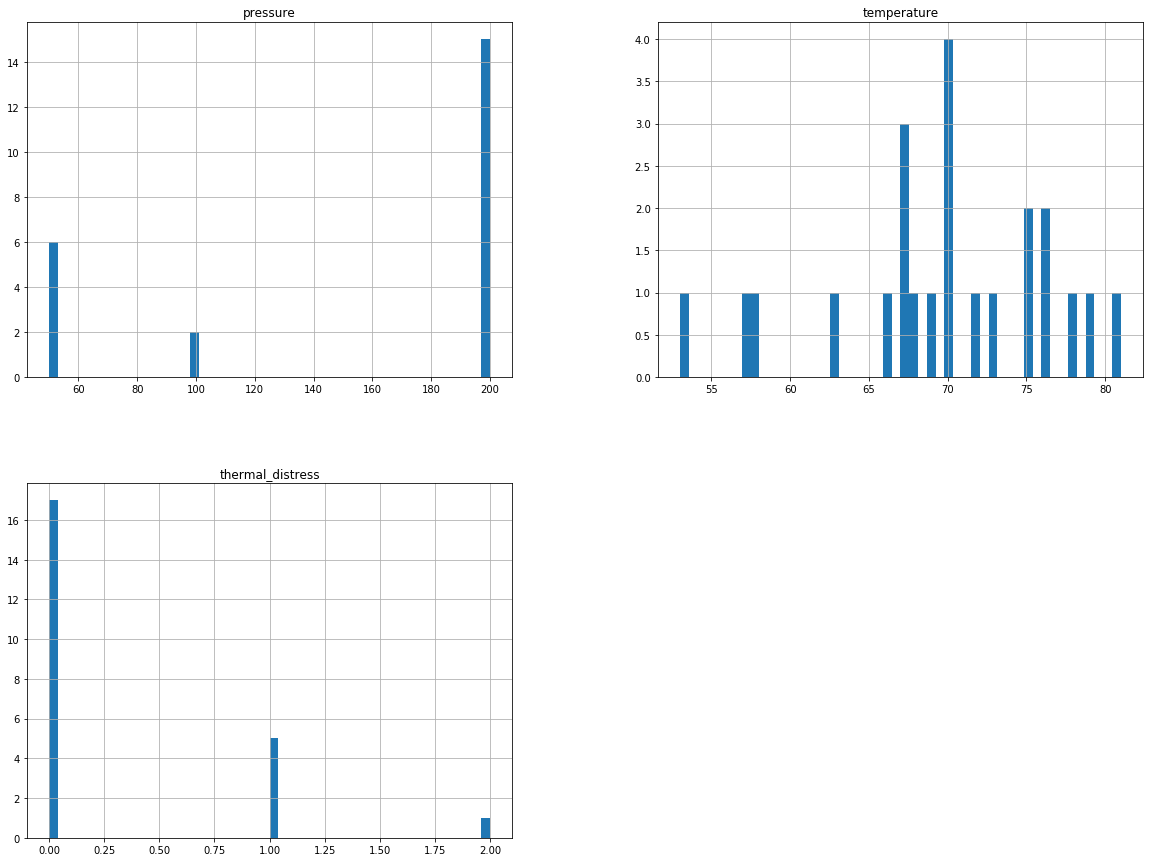

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
sf.hist(bins=50, figsize=(20,15))
plt.savefig("attribute_histogram_plots")
plt.show()

Observations: 

1. These variables have very different scales. We will discuss this later in this chapter when we explore feature scaling.

2. Many histograms are right skewed: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distributions.

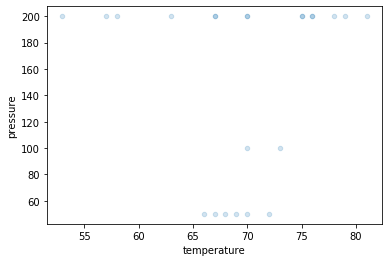

In [5]:
sf.plot(kind="scatter", x="temperature", y="pressure", alpha=0.2)
plt.savefig('map1.png')

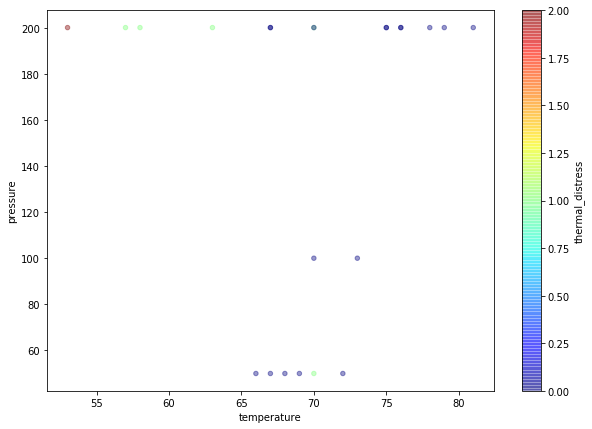

In [6]:
sf.plot(kind="scatter", x="temperature", y="pressure", alpha=0.4, figsize=(10,7),
    c="thermal_distress", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.savefig('map2.png')

Now let’s look at how much each independent variable correlates with the last sold price.

In [7]:
corr_matrix = sf.corr()
corr_matrix["thermal_distress"].sort_values(ascending=False)

thermal_distress    1.000000
pressure            0.220326
temperature        -0.725671
Name: thermal_distress, dtype: float64

The number of O-rings that experience thermal distress on a flight tends to go up when the temperature goes down. You can see a small positive correlation between the pressure and the number of O-rings that experience thermal distress on a flight. 

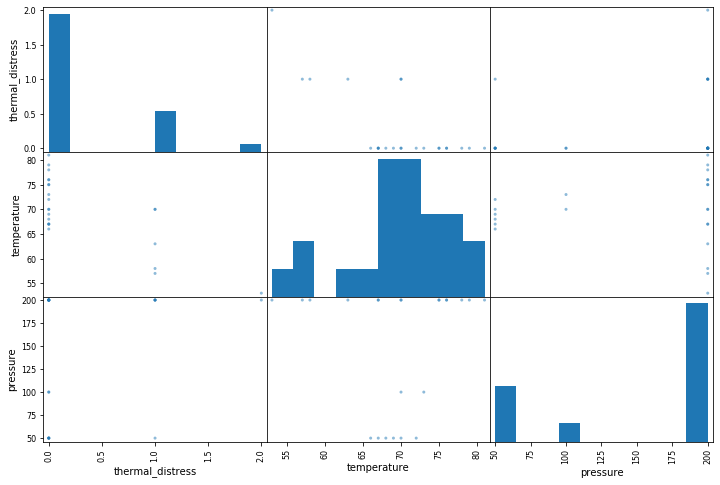

In [8]:
from pandas.plotting import scatter_matrix

attributes = ["thermal_distress", "temperature", "pressure"]
scatter_matrix(sf[attributes], figsize=(12, 8))
plt.savefig('matrix.png')

The most promising variable to predict the number of O-rings that experience thermal distress on a flight is the temperature, so let’s zoom in on their correlation scatterplot

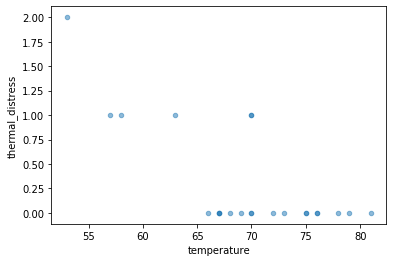

In [9]:
sf.plot(kind="scatter", x="temperature", y="thermal_distress", alpha=0.5)
plt.savefig('scatter.png')

In [10]:
sf.head()

,thermal_distress,temperature,pressure
0,0,66,50
1,1,70,50
2,0,69,50
3,0,68,50
4,0,67,50


In [11]:
X = sf[['temperature', 'pressure']]
Y = sf['thermal_distress']

In [12]:
X.head()

,temperature,pressure
0,66,50
1,70,50
2,69,50
3,68,50
4,67,50


In [13]:
X.shape

(23, 2)

In [14]:
Y.shape

(23,)

Standardization of the data

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [17]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Done! We now have a working Linear Regression model.

In [18]:
y_pred = regressor.predict(X_test)
print('Liner Regression R squared: %.4f' % regressor.score(X_test, y_test))

Liner Regression R squared: 0.2900


So, in our model, 29.00% of the variability in Y can be explained using X. It is so poor.

Calculate root-mean-square error (RMSE)

In [19]:
import numpy as np
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(y_pred, y_test)
lin_rmse = np.sqrt(lin_mse)
print('Liner Regression RMSE: %.4f' % lin_rmse)

Liner Regression RMSE: 0.6138


Our model was able to predict the number of O-rings of every flight in the test set within 0.6138 of the real number of O-rings.

Calculate mean absolute error (MAE)

In [20]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(y_pred, y_test)
print('Liner Regression MAE: %.4f' % lin_mae)

Liner Regression MAE: 0.4686


let’s try a more complex model to see whether results can be improved - the RandomForestRegressor

In [21]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [22]:
print('Random Forest R squared": %.4f' % forest_reg.score(X_test, y_test))

Random Forest R squared": 0.1703


In [23]:
y_pred = forest_reg.predict(X_test)
forest_mse = mean_squared_error(y_pred, y_test)
forest_rmse = np.sqrt(forest_mse)
print('Random Forest RMSE: %.4f' % forest_rmse)

Random Forest RMSE: 0.6635


Much worse! Let's try one more.

In [24]:
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
model = ensemble.GradientBoostingRegressor()
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [25]:
print('Gradient Boosting R squared": %.4f' % model.score(X_test, y_test))

Gradient Boosting R squared": 0.1921


In [26]:
y_pred = model.predict(X_test)
model_mse = mean_squared_error(y_pred, y_test)
model_rmse = np.sqrt(model_mse)
print('Gradient Boosting RMSE: %.4f' % model_rmse)

Gradient Boosting RMSE: 0.6547


I would consider this is our final model, let's print out feature importance

In [27]:
feature_labels = np.array(['temperature', 'pressure'])
importance = model.feature_importances_
feature_indexes_by_importance = importance.argsort()[::-1]
for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels[index], (importance[index] *100.0)))

temperature-100.00%
pressure-0.00%
